In [65]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
import math
from xmovie import Movie
import xrft
import nfft

%matplotlib inline

/home/hgrosselindemann/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Lat: 23.15.25 LON: 119.41.2


In [51]:
input_path = '/home/hgrosselindemann/Documents/TORI/'

data = pd.read_excel(input_path + 'dongji.xlsx').to_xarray()
data = data.assign_coords({'index':data.Date}).drop('Date').rename({'index':'time'})

wind = xr.open_dataset(input_path + 'ERA5_10m_winds.nc')

vel = xr.open_dataset(input_path + 'velocity_raw_filtered.nc')

dongji_lon = 119.68
dongji_lat = 23.25

wind = wind.sel(longitude=find_nearest(wind.longitude,dongji_lon)[0],latitude=find_nearest(wind.latitude,dongji_lat)[0],time=slice('2013-06-01','2013-08-31'))
vel = vel.isel(x=11,y=25).sel(time=slice('2013-06-01','2013-08-31'))


In [21]:
def find_nearest(array, value):
    '''
    finds value and idx of value in array that is closest to the looked for value
    '''
    array = np.asarray(array)
    idx = np.unravel_index(np.abs(array - value).argmin(), array.shape)
    return array[idx],idx

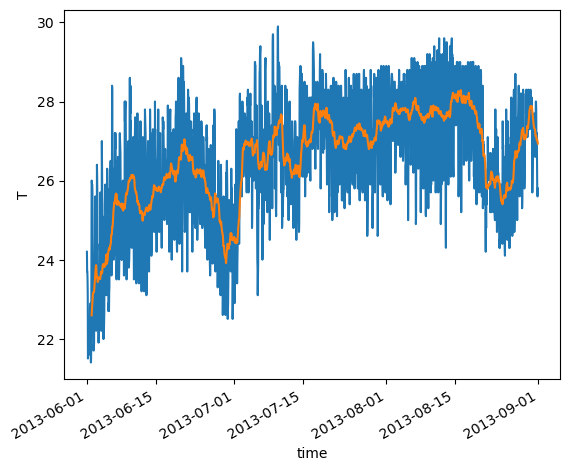

In [4]:
data.T.plot()
smoothed = data.T.rolling(time=24).mean()
# smoothed = smoothed[~np.isnan(smoothed)]
smoothed.plot()
daily = data.T.resample(time='1D').mean()
# daily.plot()

In [5]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [49]:
def demean_xarray(da,dim):
    return da - da.mean(dim=dim),da.mean(dim=dim)

def detrend_xarray(da):
    '''
    apply detrend along time axis of 2D Xarray
    see polynomial_detrend for details about detrending
    '''
    dt = xr.apply_ufunc(
                polynomial_detrend,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['time','dim0']],
                vectorize=True,
                output_dtypes=[da.dtype],
                dask="parallelized",
            )
    if 'x' in da.dims:
        dt = dt.transpose('time','y','x','dim0')
    elif 'lon' in da.dims:
        dt = dt.transpose('time','lat','lon','dim0')
    
    return dt.isel(dim0=0),dt.isel(dim0=1)

def polynomial_detrend(da,order=1):
    '''
    detrend of non uniform data on a uniform grid with nan values
    
    change order to increase order of fittet polynomial, default is 1, so linear
    
    returns detrended data and trend values
    '''
    ds = da.copy()
    mask = ~np.isnan(ds)
    if mask.sum() == 0:
        return np.stack((ds,ds),axis=-1)
    else:
        ds_masked = ds[mask]
        time = np.arange(0,len(ds))
        time_masked = time[mask]
        coeff = np.polyfit(time_masked, ds_masked, order)
        trend_nonan = np.polyval(coeff, time_masked)
        detrended = ds_masked - trend_nonan
        ds[mask] = detrended
        trend = np.copy(ds)
        trend[mask] = trend_nonan
        
        return np.stack((ds.data,trend),axis=-1)

In [62]:
def nufft(data,xarray_apply=True):
    '''
    does a non-uniform fast fourier transform on data with a uniform grid but nan values in it
    
    returns freq: frequency in cycles per timestep (cph for hourly data)
            f_k: amplitude for each wavenumber k as a complex number
            ps: power spectrum
            psd: power spectral density
            
    xarray_apply is used for the spectral_analysis function for apply_ufunc along time dimension for each point of spatial array
        if you just want to do it for one array time series, set it to False
    
    function is taken from https://github.com/jakevdp/nfft
    '''
    mask = ~np.isnan(data)
    
    N_freq = len(data)
    k = -N_freq//2 + np.arange(N_freq)
    
    data_masked = (data)[mask]
    t = np.linspace(0, 1,N_freq)[mask]
    
    f_k = nfft.nfft_adjoint(t,data_masked,N_freq)
    ps = np.abs(f_k)**2/N_freq**2
    psd = ps * N_freq
    freq = k/N_freq
    if xarray_apply == True:
        t_return = np.linspace(0, 1,N_freq)
        t_return[~mask] = np.nan
        return np.stack((freq,f_k,ps,psd,t_return),axis=-1)
    elif xarray_apply==False:
        return freq,f_k,ps,psd,t

In [53]:
data['demeaned'],mean = demean_xarray(data.T,dim='time')
data = data.assign({'detrended':('time',polynomial_detrend(data.demeaned)[:,0])})

vel['u_demeaned'],mean = demean_xarray(vel.u,dim='time')
vel = vel.assign({'u_detrended':('time',polynomial_detrend(vel.u_demeaned)[:,0])})
vel['v_demeaned'],mean = demean_xarray(vel.v,dim='time')
vel = vel.assign({'v_detrended':('time',polynomial_detrend(vel.v_demeaned)[:,0])})

In [8]:
data_hann = data.detrended * np.hanning(len(data.T))

In [66]:
freqt,fkt,pst,psdt,tt = nufft(data.detrended,xarray_apply=False)
frequ,fku,psu,psdu,tu = nufft(vel.u_detrended,xarray_apply=False)
freqv,fkv,psv,psdv,tv = nufft(vel.v_detrended,xarray_apply=False)

# freq_hann,ps_hann,psd_hann = spectrum1(data_hann)

# ps_xrft = ps_xrft.assign_coords({'freq_time':ps_xrft.freq_time*3600*24})
# ps_xrft_hann = ps_xrft_hann.assign_coords({'freq_time':ps_xrft_hann.freq_time*3600*24})

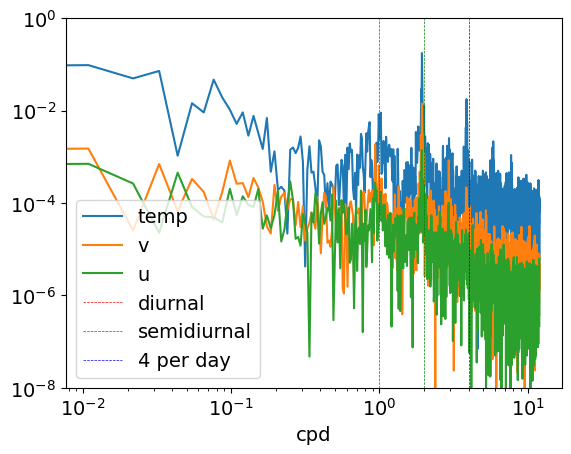

In [105]:
plt.loglog(freqt*24,pst,label='temp')
plt.loglog(freqv*24,psv,label='v')
plt.loglog(frequ*24,psu,label='u')

# plt.loglog(freq_hann*24,ps_hann)#,label='hanning')

ymin,ymax = 1e-8,1e0
plt.vlines(1,ymin,ymax,color='r',linestyle='--',linewidth=0.5,label='diurnal')
plt.vlines(2,ymin,ymax,color='g',linestyle='--',linewidth=0.5,label='semidiurnal')
plt.vlines(4,ymin,ymax,color='b',linestyle='--',linewidth=0.5,label='4 per day')

# plt.vlines(8e-2,ymin,ymax,color='y',linestyle='--',linewidth=0.5,label='12 days')


plt.legend()
plt.ylim([ymin,ymax])
plt.xlabel('cpd');

In [72]:
def crossSpectrum(x, y, nperseg):
    '''
    calculate the cross spectrum between two time series
    uses a non-uniform FFT for spectral amplitudes
    applies welch's method with a hanning window of size nperseg
    and 50% overlap
    
    input:
        x,y: time series data as numpy array
        nperseg: window size for welch's method
    returns:
        cross-spectral amplitudes
        frequencies
    '''
    cross = np.zeros(nperseg, dtype='complex128')
    for ind in np.arange(0, int(len(x)/nperseg)-0.5, 0.5):
        xp = x[int(ind * nperseg): int((ind + 1)*nperseg)]
        xp = xp - np.mean(xp)
        xp = xp*np.hanning(nperseg)

        yp = y[int(ind * nperseg): int((ind + 1)*nperseg)]
        yp = yp - np.mean(yp)
        yp = yp*np.hanning(nperseg)

        # Do FFT
        freqxi, cfxi, psxi, psdxi, txi = nufft(xp, xarray_apply=False)
        freqyi, cfyi, psyi, psdyi, tyi = nufft(yp, xarray_apply=False)

    # Get cross spectrum
        cross += cfxi.conj()*cfyi
    freq = (-nperseg//2 + np.arange(nperseg))/nperseg
    return np.stack((cross, freq), axis=-1)

# coherence = abs(Pxy)**2/(Pxx*Pyy)

In [112]:
nperseg = 256

pxx = crossSpectrum(data.T+0*1j,data.T+0*1j,nperseg=nperseg)
pyy = crossSpectrum(vel.u+1j*vel.v,vel.u+1j*vel.v,nperseg=nperseg)
pxy = crossSpectrum(data.T+0*1j,vel.u+1j*vel.v,nperseg=nperseg)

freq = np.array([pxy[i][1].real for i in range(nperseg)])
pxx = np.array([pxx[i][0] for i in range(nperseg)])
pyy = np.array([pyy[i][0] for i in range(nperseg)])
pxy = np.array([pxy[i][0] for i in range(nperseg)])

coh = np.abs(pxy)**2/pxx.real/pyy.real

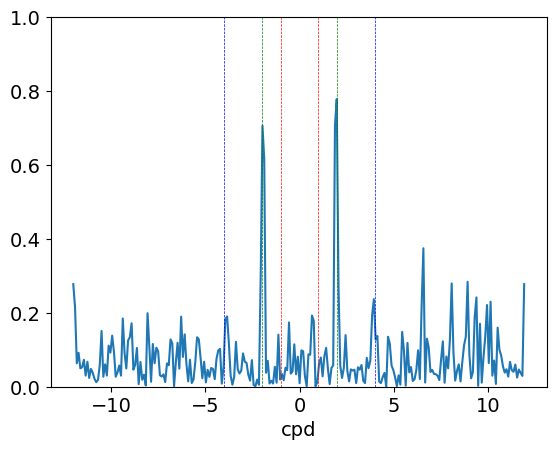

In [113]:
plt.plot(freq*24,coh)
ymin,ymax = 0,1
plt.vlines([-1,1],ymin,ymax,color='r',linestyle='--',linewidth=0.5,label='diurnal')
plt.vlines([-2,2],ymin,ymax,color='g',linestyle='--',linewidth=0.5,label='semidiurnal')
plt.vlines([-4,4],ymin,ymax,color='b',linestyle='--',linewidth=0.5,label='4 per day')

# plt.vlines(8e-2,ymin,ymax,color='y',linestyle='--',linewidth=0.5,label='12 days')


plt.ylim([ymin,ymax])
plt.xlabel('cpd');

In [11]:
wind['abs'] = np.sqrt(wind.u10**2 + wind.v10**2)

In [12]:
wind = wind.assign({'dir':('time',[(270-math.atan2(v,u)*180/np.pi)%360 for u,v in zip(wind.u10.data,wind.v10.data) ])})
wind_daily = wind.resample(time='1D').mean()

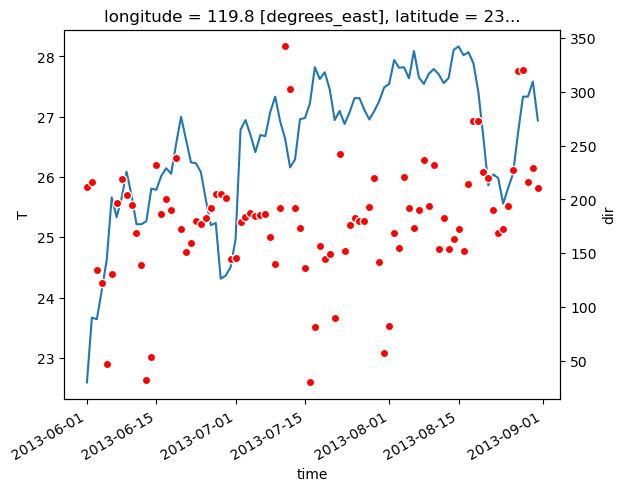

In [13]:
fig,ax1 = plt.subplots(1,1)
ax2 = plt.twinx()
daily.plot(ax=ax1)
xr.plot.scatter(wind_daily,x='time',y='dir',ax=ax2,color='r')

In [14]:
r,p=scipy.stats.pearsonr(data.detrended,wind.abs)
print(f'r={r:.2f}')
print(f'p={p:.2f}')

r=-0.12
p=0.00


In [17]:
freq,coh = scipy.signal.coherence(data.T.data + 1j*0,(wind.u10 + 1j*wind.v10).data)
freq = np.sort(freq)
coh = np.concatenate((coh[128:],coh[:128]))

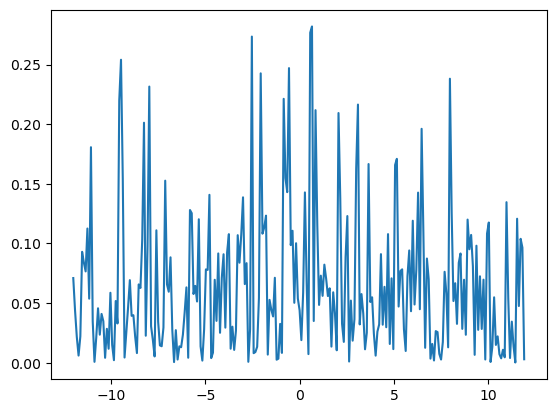

In [16]:
plt.plot(freq*24,coh)

# Movie

In [8]:
temp = pd.read_excel(input_path + 'dongji.xlsx').to_xarray()

temp = temp.assign_coords({'index':temp.Date}).drop('Date').rename({'index':'time'})
temp_daily = temp.resample(time='1D').mean()

wind = xr.open_dataset(input_path + 'ERA5_10m_winds.nc')
wind = wind.sel(time=slice('2013-06-01','2013-08-31'))
wind_daily = wind.resample(time='1D').mean()

mov_data = xr.merge([temp_daily,wind_daily])

In [69]:
fig = plt.figure(figsize=(10,10))

def custom_plotfunc(ds,fig,tt,framedim='time',**kwargs):
    ax = fig.add_subplot(121,projection=ccrs.PlateCarree())
    ds.isel({framedim:tt}).plot.quiver('longitude','latitude','u10','v10',ax=ax,add_guide=False,label='ERA5 10m Winds')
    ax.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
    gl = ax.gridlines(draw_labels=True)
    ax.set_title(str(ds.isel(time=tt).time.values)[:10])
    gl.right_labels=False
    gl.top_labels=False
    ax.scatter(119.75,23.23,marker='x',color='r',label='Dongji')
    ax.legend(loc='upper left')
    
    ax1 = fig.add_subplot(122)
    ax1.set_xlim([datetime(2013,6,1),datetime(2013,9,1)])
    ax1.set_xticks([datetime(2013,6,1),datetime(2013,6,15),datetime(2013,7,1),datetime(2013,7,15),
                    datetime(2013,8,1),datetime(2013,8,15),datetime(2013,9,1)],
                   ['06-01','06-15','07-01','07-15','08-01','08-15','09-01'])
    ax1.set_ylim([21,30])
    ds.isel(time=slice(0,tt+2)).T.plot(ax=ax1)
    ax1.set_xlabel(''),ax1.set_ylabel('temperature [degC]')
    return None,None
    


<Figure size 1000x1000 with 0 Axes>

In [70]:
mov = Movie(mov_data,custom_plotfunc,input_check=False)

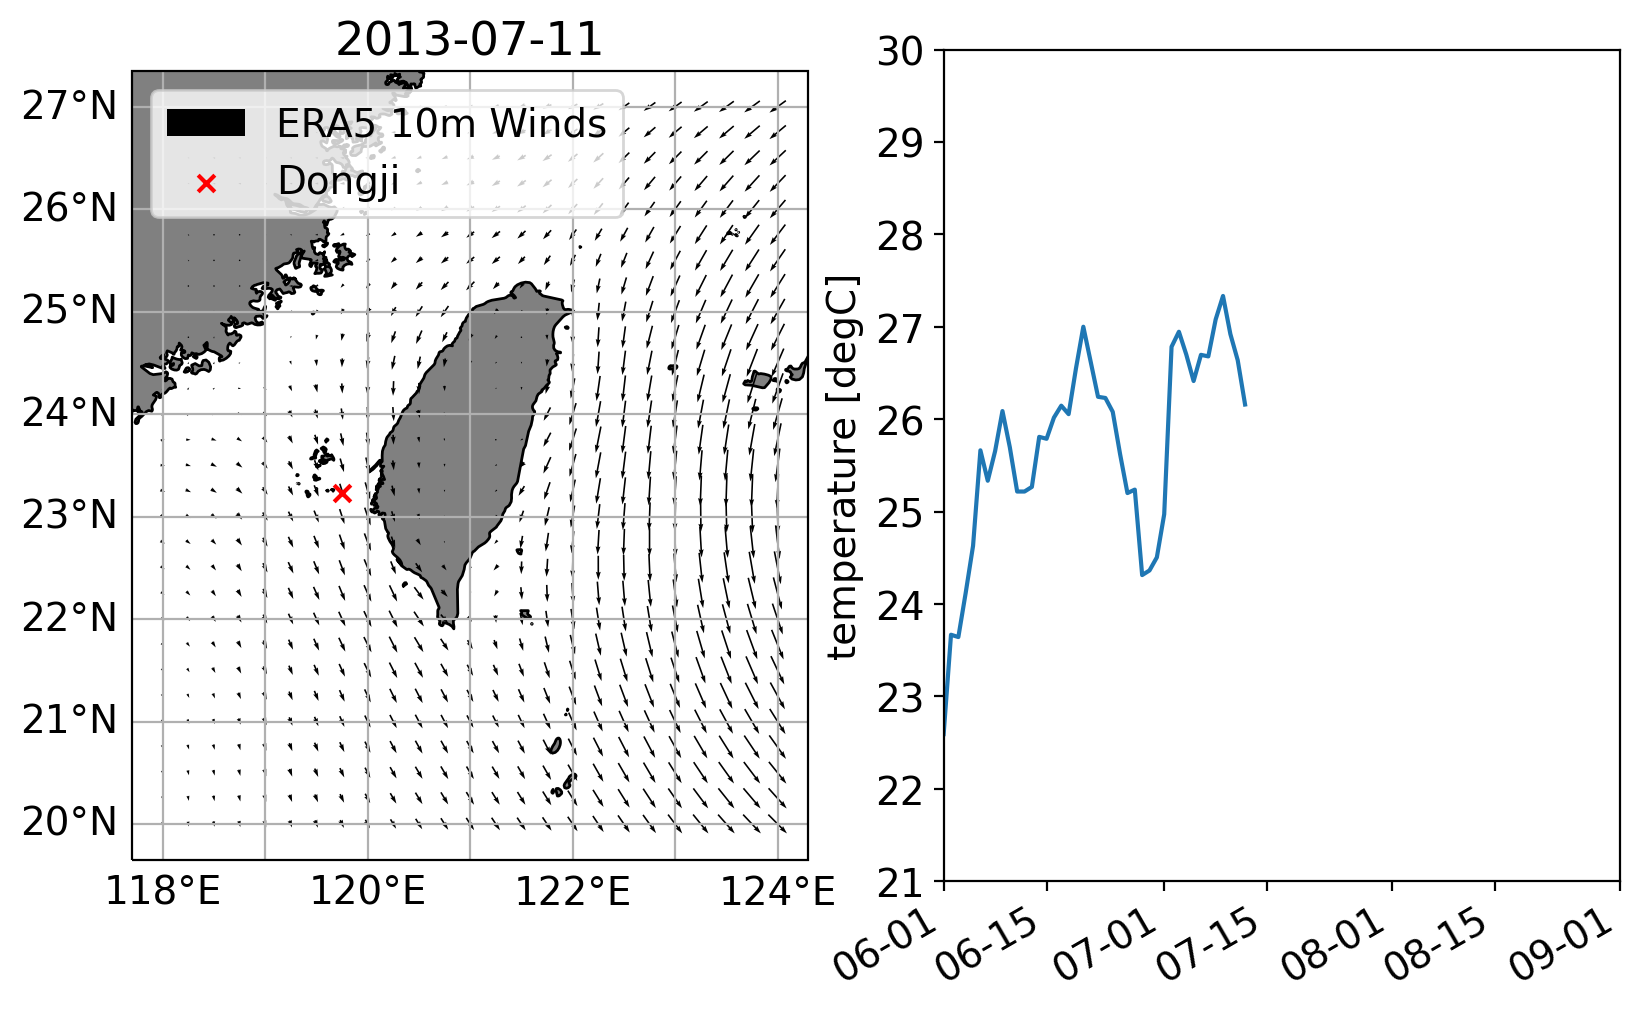

In [71]:
mov.preview(40)

In [72]:
mov.save('dongji.mp4',overwrite_existing=True,framerate=2)

Movie created at dongji.mp4
